In [1]:
from time import time
import re
import gc

import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
pd.options.display.max_columns = 999
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

from hyperopt import tpe, hp, fmin, Trials
from IPython.display import clear_output

import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
        `float64` type to `float32`
        `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Loading Datasets

In [3]:
DATA_PATH = 'E:/Kaggle/Avito/'

seed = 32
FOLDS = 5
min_class_cat = 50

In [4]:
train = pd.read_csv(DATA_PATH+'train.csv')
test = pd.read_csv(DATA_PATH+'test.csv')
guess_image = pd.read_csv(DATA_PATH+'image_guess.csv')
price_guess  = pd.read_csv(DATA_PATH+'price_guess.csv')
param_guess  = pd.read_csv(DATA_PATH+'param_guess.csv')
param2_guess  = pd.read_csv(DATA_PATH+'param2_guess.csv')

images0 = pd.read_csv(DATA_PATH+'image0_features.csv')
images1 = pd.read_csv(DATA_PATH+'image1_features.csv')
images2 = pd.read_csv(DATA_PATH+'image2_features.csv')
images3 = pd.read_csv(DATA_PATH+'image3_features.csv')
images4 = pd.read_csv(DATA_PATH+'image4_features.csv')
imagestest = pd.read_csv(DATA_PATH+'imagetest_features.csv')
imagesdata = pd.concat([images0,images1,images2,images3,images4,imagestest],axis=0)

user_agg = pd.read_csv(DATA_PATH+'user_aggregated_features.csv')

In [5]:
kf = KFold(FOLDS,random_state=seed,shuffle=True)
Fold = 0
for train_index, test_index in kf.split(train):
    train.loc[test_index,'Fold']=Fold
    Fold += 1

In [6]:
complete_data = pd.concat([train,test],axis=0,ignore_index=True)
complete_data = pd.merge(complete_data,guess_image,how='left')
complete_data = pd.merge(complete_data,price_guess,how='left')
complete_data = pd.merge(complete_data,param_guess,how='left')
complete_data = pd.merge(complete_data,param2_guess,how='left')
complete_data = pd.merge(complete_data,imagesdata,how='left')
complete_data = pd.merge(complete_data,user_agg,how='left',on='user_id')
del guess_image, price_guess, param_guess, param2_guess, imagesdata, user_agg

## Feature Engineering

In [7]:
complete_data['missing_param_1'] = complete_data['param_1'].isnull().astype(int)
complete_data['missing_param_2'] = complete_data['param_2'].isnull().astype(int)
complete_data['missing_param_3'] = complete_data['param_3'].isnull().astype(int)
complete_data['missing_desc'] = complete_data['description'].isnull().astype(int)
complete_data['missing_price'] = complete_data['price'].isnull().astype(int)
complete_data['missing_image'] = complete_data['image'].isnull().astype(int)
complete_data['number_missings'] = complete_data['missing_param_1']+complete_data['missing_param_2']+complete_data['missing_image']+\
                                    complete_data['missing_param_3']+complete_data['missing_desc']+complete_data['missing_price'] 
del complete_data['missing_param_1'] 
del complete_data['missing_param_2'] 
del complete_data['missing_param_3']
del complete_data['missing_desc'] 
del complete_data['missing_price'] 
del complete_data['missing_image']

In [8]:
temp = complete_data.groupby(['user_id'],as_index=False).agg({'item_id':'count'}).rename(columns={'item_id':'count_item'})
big_users = set(temp[temp['count_item']>=5]['user_id'])
complete_data['user_id'] = np.where(complete_data['user_id'].isin(big_users),complete_data['user_id'],'SmallUser')

In [9]:
complete_data['log_price']=np.log(complete_data['price']+0.01)

In [10]:
complete_data['city_counts']=complete_data.groupby(['city'])['item_id'].transform('count')

In [11]:
complete_data['region_counts']=complete_data.groupby(['region'])['item_id'].transform('count')
complete_data['category_name_counts']=complete_data.groupby(['category_name'])['item_id'].transform('count')
complete_data['Guess_image_top1_counts']=complete_data.groupby(['Guess_image_top1'])['item_id'].transform('count')

In [12]:
complete_data['price'].fillna(-999,inplace=True)
complete_data['log_price'].fillna(-999,inplace=True)
complete_data['price_10']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//10).astype(str).apply(lambda x: x[-1]),-999).astype(int)
complete_data['price_100']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//100).astype(str).apply(lambda x: x[-1]),-999).astype(int)
complete_data['price_1000']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//1000).astype(str).apply(lambda x: x[-1]),-999).astype(int)
complete_data['price_10000']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//10000).astype(str).apply(lambda x: x[-1]),-999).astype(int)
complete_data['price_100000']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//100000).astype(str).apply(lambda x: x[-1]),-999).astype(int)

In [13]:
complete_data['log_item_seq']=np.log(0.01+complete_data['item_seq_number'])

In [14]:
complete_data['param_1'].fillna('Unknown',inplace=True)
complete_data['param_2'].fillna('Unknown',inplace=True)
complete_data['param_3'].fillna('Unknown',inplace=True)
complete_data['image_top_1'].fillna('Unknown',inplace=True)

In [15]:
temp = train.groupby(['city'],as_index=False).agg({'item_id':'count'}).rename(columns={'item_id':'count_item'})
big_cities = set(temp[temp['count_item']>=min_class_cat]['city'])
complete_data['city_clean'] = np.where(complete_data['city'].isin(big_cities),complete_data['city'],'SmallCity')

In [16]:
uppercase_regex = re.compile(r'[A-ZА-Я]')
symbols_regex = re.compile(r'[^a-zA-ZА-Я0-9а-я]')
digits_regex = re.compile(r'[0-9]')

In [17]:
complete_data['title_number_uppercase'] = complete_data['title'].str.count(uppercase_regex)
complete_data['title_number_symbols'] = complete_data['title'].str.count(symbols_regex)
complete_data['title_number_digits'] = complete_data['title'].str.count(digits_regex)
complete_data['title_len_chars'] = complete_data['title'].apply(lambda x: len(str(x)))
complete_data['title_len_words'] = complete_data['title'].str.split().apply(lambda x: len(str(x)))
complete_data['title_unique'] = complete_data['title'].str.split().apply(lambda x: len(set(str(x))))
complete_data['share_unique_title'] = complete_data['title_unique']/complete_data['title_len_words']

In [18]:
complete_data['desc_number_uppercase'] = complete_data['description'].str.count(uppercase_regex)
complete_data['desc_number_symbols'] = complete_data['description'].str.count(symbols_regex)
complete_data['desc_number_digits'] = complete_data['description'].str.count(digits_regex) #should do similar stuff for param
complete_data['desc_len_char']=complete_data['description'].apply(lambda x: len(str(x)))
complete_data['desc_len_words']=complete_data['description'].str.split().apply(lambda x: len(str(x)))
complete_data['desc_unique'] = complete_data['description'].str.split().apply(lambda x: len(set(str(x))))
complete_data['share_unique_desc'] = complete_data['desc_unique']/complete_data['desc_len_words']
complete_data['desc_rows'] = complete_data['description'].astype(str).apply(lambda x: x.count('/\n'))
complete_data['r_title_desc'] = complete_data['title_len_chars']/(complete_data['desc_len_char']+1)
complete_data['desc_number_uppercase'].fillna(-999,inplace=True)
complete_data['desc_number_symbols'].fillna(-999,inplace=True)
complete_data['desc_number_digits'].fillna(-999,inplace=True)
complete_data['desc_len_char'].fillna(-999,inplace=True)
complete_data['desc_len_words'].fillna(-999,inplace=True)
complete_data['desc_unique'].fillna(-999,inplace=True)
complete_data['share_unique_desc'].fillna(-999,inplace=True)
complete_data['desc_rows'].fillna(-999,inplace=True)
complete_data['r_title_desc'].fillna(-999,inplace=True)

In [19]:
for var in ['img_size', 'lightness','darkness','pixel_width','avg_red','avg_green','avg_blue','width','height','blurness']:
    complete_data[var].fillna(-999,inplace=True)
for var in ['usermean_days_up_sum','usermean_days_up_count','usermean_days_up_avg','usermean_days_until_activation_sum','usermean_days_until_activation_avg',
            'userstd_days_up_sum','userstd_days_up_count','userstd_days_up_avg','userstd_days_until_activation_sum','userstd_days_until_activation_avg','usermedian_days_up_sum',
            'usermedian_days_up_count','usermedian_days_up_avg','usermedian_days_until_activation_sum','usermedian_days_until_activation_avg','n_user_items']:
    complete_data[var].fillna(-999,inplace=True)

In [20]:
english_stopwords = set(stopwords.words('english'))
russian_stopwords = set(stopwords.words('russian'))
russian_stopwords = russian_stopwords.union(english_stopwords)

In [21]:
#Svd Title
n_components_title = 5 #best between 20 and 30
colnames_svdtitle = ['svd_title_'+str(x) for x in range(n_components_title)]
wordVectTitle = TfidfVectorizer(min_df=2, #Reduce some overfitting (to try in hyper opt)
                                max_df=0.5,
                                ngram_range=(1,3),
                                stop_words = russian_stopwords
                               )
title_sparse = wordVectTitle.fit_transform(complete_data['title'])
svd_title = TruncatedSVD(n_components=n_components_title)
title_sparse_proj  = svd_title.fit_transform(title_sparse).astype('float32')
complete_data = pd.concat([complete_data,pd.DataFrame(title_sparse_proj,columns=colnames_svdtitle)],axis=1)
del title_sparse_proj, title_sparse

In [22]:
#Svd Description
n_components_desc = 5 #best between 35 and 50
colnames_svddesc = ['svd_desc_'+str(x) for x in range(n_components_desc)]
wordVectDesc = TfidfVectorizer(min_df=2,
                                max_df=0.5,
                                ngram_range=(1,2),
                                stop_words = stopwords.words('russian')
                               )
desc_sparse = wordVectDesc.fit_transform(complete_data['description'].astype(str))
svd_desc = TruncatedSVD(n_components=n_components_desc)
desc_sparse_proj  = svd_desc.fit_transform(desc_sparse).astype('float32')
complete_data = pd.concat([complete_data,pd.DataFrame(desc_sparse_proj,columns=colnames_svddesc)],axis=1)
del desc_sparse_proj, desc_sparse

In [23]:
#CountVect Title
wordVectTitle = CountVectorizer(lowercase=True,analyzer='word',
                             stop_words=russian_stopwords,token_pattern=r'\w+',
                             ngram_range=(1,2),dtype=np.float32,min_df=2)
title_sparse = wordVectTitle.fit_transform(complete_data['title'].astype(str))

In [24]:
#TFIDF Description
tfidf_desc = TfidfVectorizer(lowercase=True,analyzer='word',
                             stop_words=russian_stopwords,token_pattern=r'\w+',
                             max_features=15000,
                             ngram_range=(1,1),dtype=np.float32,norm='l2',smooth_idf=False,sublinear_tf=True,min_df=5,max_df=0.5)
desc_sparse = tfidf_desc.fit_transform(complete_data['description'].astype(str))

In [25]:
complete_data['params'] = complete_data['param_1']+' '+complete_data['param_2']+' '+complete_data['param_3']
wordVectParams = CountVectorizer(lowercase=True,analyzer='word',
                             stop_words=russian_stopwords,token_pattern=r'\w+',
                             ngram_range=(1,1),dtype=np.float32,min_df=2,max_features=15000)
params_sparse = wordVectParams.fit_transform(complete_data['params'].astype(str))

In [26]:
sparse = hstack([title_sparse,desc_sparse,params_sparse],format='csr').astype('float32')
sparse

<2011862x31839 sparse matrix of type '<class 'numpy.float32'>'
	with 47658578 stored elements in Compressed Sparse Row format>

In [27]:
temp = complete_data.isnull().sum()
temp[temp>0]

Fold                508438
deal_probability    508438
description         116276
image               155197
dtype: int64

In [28]:
complete_data = downcast_dtypes(complete_data)
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011862 entries, 0 to 2011861
Columns: 158 entries, Fold to params
dtypes: float32(111), int32(24), object(23)
memory usage: 1.4+ GB


In [29]:
gc.collect()

42

In [30]:
categoricals = ['param_1','image_top_1','city_clean','user_type']
categoricals += ['Guess_image_top1','Guess_image_top2','category_name']
categoricals += ['param_2','param_3']
categoricals += ['user_id']
categoricals += ['price_10','price_100','price_1000', 'price_10000']
categoricals += ['Guess_param_top1', 'Guess_param_top2','Guess_param_top3']
categoricals += ['Guess_param2_top1', 'Guess_param2_top2']

numericals = ['log_price','log_item_seq','Prob_image_top1','number_missings','city_counts']
numericals += ['title_number_uppercase','title_number_symbols','title_number_digits','title_len_chars','title_len_words','title_unique','share_unique_title']
numericals += ['desc_number_uppercase','desc_number_symbols','desc_number_digits','desc_len_char','desc_len_words','desc_unique','share_unique_desc','desc_rows','r_title_desc']
numericals += ['Guess_price','Prob_param_top1']
numericals += [ 'lightness','darkness','avg_red','avg_green','avg_blue','width','height','blurness']

numericals += ['usermean_days_up_sum','usermean_days_up_count','usermean_days_up_avg','usermean_days_until_activation_sum','usermean_days_until_activation_avg',
            'userstd_days_up_sum','userstd_days_up_count','n_user_items']



#numericals += colnames_svdtitle
#numericals += colnames_svddesc

features = categoricals + numericals

feature_names = features.copy()
feature_names += ['title_' + x for x in wordVectTitle.get_feature_names()]
feature_names += ['desc_' + x for x in tfidf_desc.get_feature_names()]
feature_names += ['params_' + x for x in wordVectParams.get_feature_names()]

In [31]:
le = LabelEncoder()
for col in categoricals:
    complete_data[col] = le.fit_transform(complete_data[col].astype(str))

## Model

In [32]:
train_indexes = np.where(complete_data['deal_probability'].notnull())[0]
test_indexes = np.where(complete_data['deal_probability'].isnull())[0]

X_all = complete_data[features]
X_all = hstack([csr_matrix(X_all),sparse],format='csr').astype('float32')

X = X_all[train_indexes,:]
X_test = X_all[test_indexes,:]
y = complete_data['deal_probability'][train_indexes].copy()
gc.collect()

7

In [33]:
lgb_params = {'learning_rate':0.02,
              'task':'train',
              'boosting_type':'gbdt',
              'metric':'rmse',
              'objective':'regression',
              'num_leaves':1000,
              'max_depth':18,
              'min_data_in_leaf':25, #Defaut 20
              'feature_fraction': 0.43,
              'feature_fraction_seed':0,
              'bagging_fraction': 0.46,
              #'bagging_freq': 2,
              'bagging_seed':0,
              'verbose':0,
              'num_threads':4 #Put to 4 if you are leaving computer
              }

E:\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
E:\Anaconda3\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[250]	train's rmse: 0.198082	valid's rmse: 0.218252
[500]	train's rmse: 0.185994	valid's rmse: 0.216832
[750]	train's rmse: 0.179883	valid's rmse: 0.216447
[1000]	train's rmse: 0.176338	valid's rmse: 0.216233
[1250]	train's rmse: 0.173466	valid's rmse: 0.216091
[1500]	train's rmse: 0.171188	valid's rmse: 0.215998
[1750]	train's rmse: 0.169165	valid's rmse: 0.215913
[2000]	train's rmse: 0.167189	valid's rmse: 0.215854
[2250]	train's rmse: 0.165416	valid's rmse: 0.215803
[2500]	train's rmse: 0.163822	valid's rmse: 0.215758
[2750]	train's rmse: 0.162216	valid's rmse: 0.215722
[3000]	train's rmse: 0.1608	valid's rmse: 0.215683
[3250]	train's rmse: 0.159393	valid's rmse: 0.215662
[3500]	train's rmse: 0.158042	valid's rmse: 0.215636
Early stopping, best iteration is:
[3525]	train's rmse: 0.157915	valid's rmse: 0.215634
Training until validation scores don't improve for 50 rounds.
[250]	train's rmse: 0.198004	valid's rmse: 0.21828


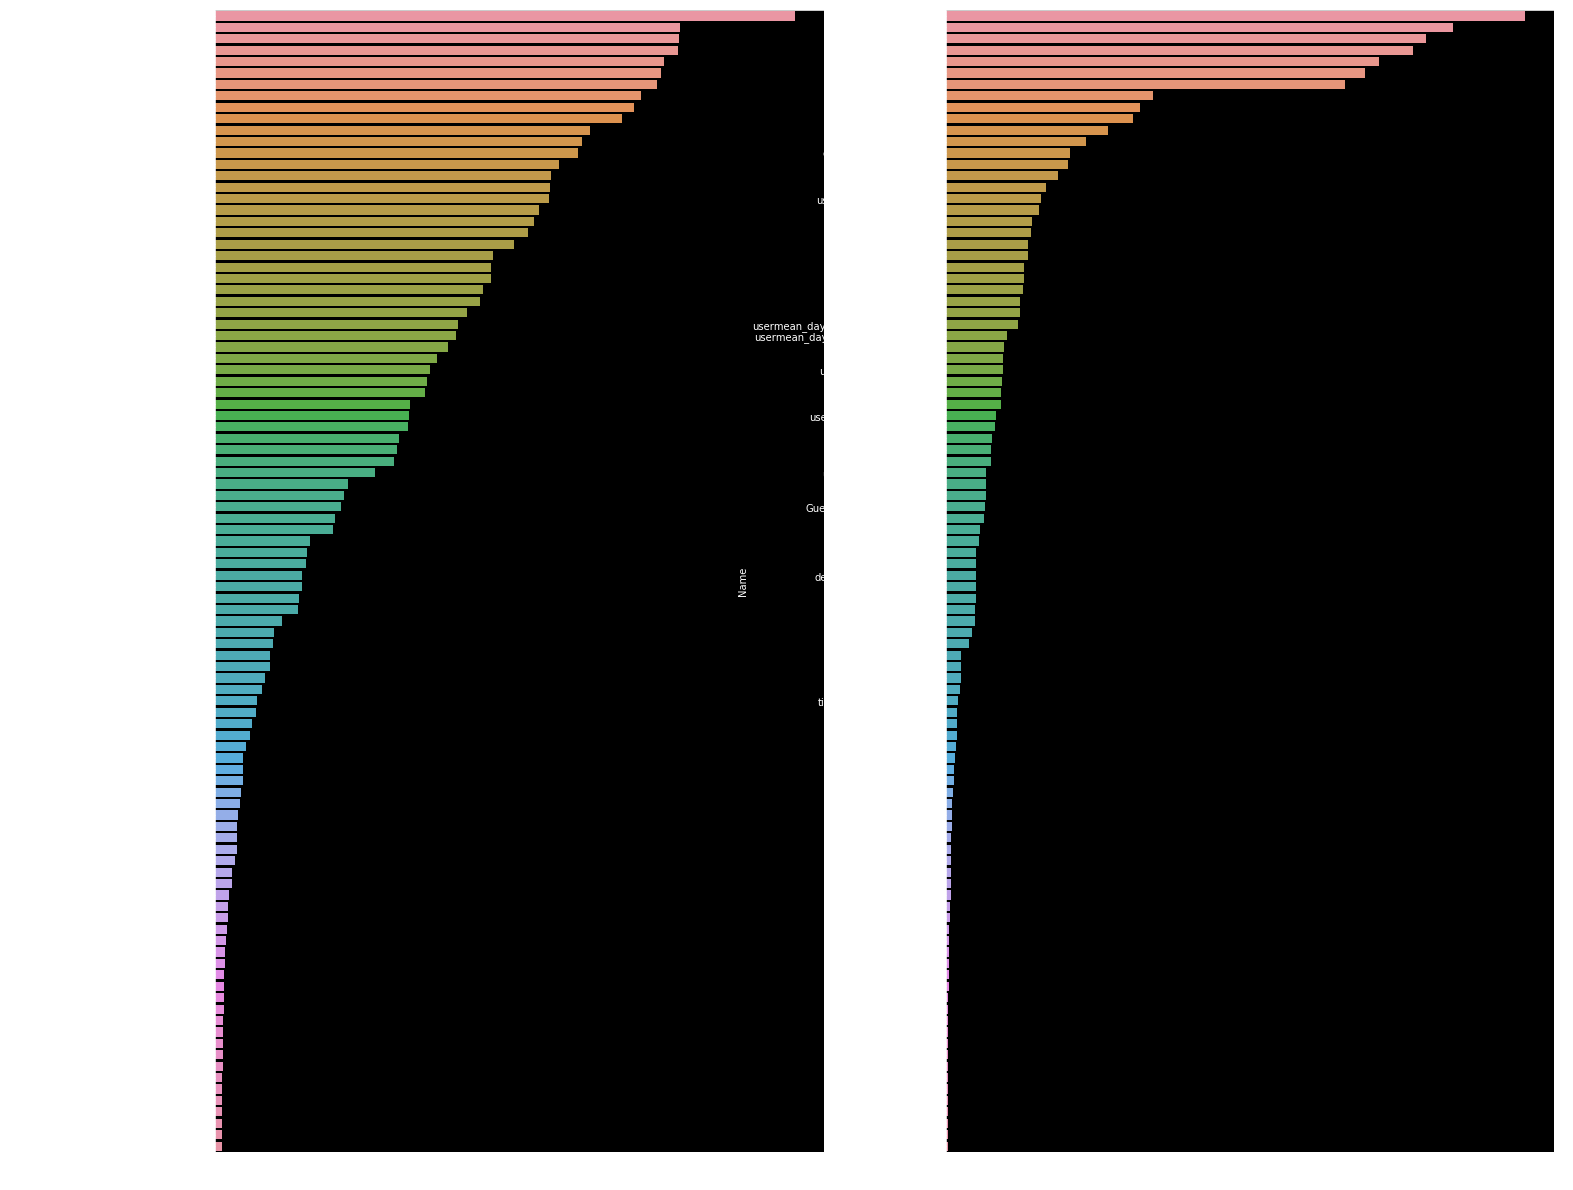

In [34]:
predict_test_kfolds = []
X_meta = np.zeros((X.shape[0],2))
X_meta[:,0]=y
X_meta_test = np.zeros((X_test.shape[0],2))

feature_importances_split = []
feature_importances_gain = []
predict_test_kfolds = []
i=0
rmse=[]
n_trees =[]

start = time()
for fold in range(FOLDS):
    val_idx =  np.where(complete_data['Fold']==fold)[0]
    train_idx = np.where((complete_data['Fold']!=fold) & (complete_data['Fold'].notnull()))[0]
    
    X_tr = X[train_idx]
    y_tr = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    
    lgtrain = lgb.Dataset(X_tr,y_tr,
            feature_name=feature_names,
            categorical_feature = categoricals)
    lgvalid = lgb.Dataset(X_val,y_val,
            feature_name=feature_names,
            categorical_feature = categoricals)

    lgb_model = lgb.train(lgb_params,lgtrain,valid_sets=[lgtrain, lgvalid],valid_names=['train','valid'],
                          verbose_eval=250,num_boost_round=10000,early_stopping_rounds=50)

    predict_val = lgb_model.predict(X_val).clip(0.0,1.0)
    r = mean_squared_error(y_val,predict_val)**0.5
    X_meta[val_idx,1]=predict_val
    
    predict_test = lgb_model.predict(X_test).clip(0.0,1.0)
    predict_test_kfolds.append(predict_test)
    
    rmse.append(r)
    n_trees.append(lgb_model.best_iteration)
    feature_importances_split.append(lgb_model.feature_importance(importance_type='split'))
    feature_importances_gain.append(lgb_model.feature_importance(importance_type='gain'))

avg_rmse = sum(rmse)/len(rmse)
avg_trees = sum(n_trees)//len(n_trees)
print('Average RMSE',avg_rmse,'Average Trees',avg_trees)
print((time()-start)//60,'Minutes')

feature_importances_split = np.stack(feature_importances_split).mean(axis=0)
feature_importances_gain = np.stack(feature_importances_gain).mean(axis=0)
importances = pd.DataFrame({'Name':feature_names,
                  'Gain':list(feature_importances_gain),
                 'Split':list(feature_importances_split)})
feature_sort = 'Split'
importances = importances.sort_values(feature_sort,ascending=False)
fig, ax = plt.subplots(figsize=(24,21),nrows=1,ncols=2)
sns.barplot(x=feature_sort, y='Name',data=importances[:100], ax=ax[0])
feature_sort = 'Gain'
importances = importances.sort_values(feature_sort,ascending=False)
sns.barplot(x=feature_sort, y='Name',data=importances[:100], ax=ax[1])
plt.show()   

In [35]:
kfold_predictions = np.stack(predict_test_kfolds).mean(axis=0)
test['deal_probability'] = kfold_predictions
test[['item_id','deal_probability']].to_csv(DATA_PATH+f'{avg_rmse:.4f}_'+'Predictions_LGB_v2.csv',index=False)

## Meta Data

In [36]:
lgtrain = lgb.Dataset(X,y,feature_name=feature_names,categorical_feature = categoricals)

lgb_model = lgb.train(lgb_params,lgtrain,num_boost_round=avg_trees)
full_predictions = lgb_model.predict(X_test).clip(0.0,1.0)
X_meta_test[:,1]=full_predictions

E:\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
E:\Anaconda3\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [37]:
Meta_data = pd.concat([pd.DataFrame(X_meta,columns=['deal_probability','LGB1']),
                      pd.DataFrame(X_meta_test,columns=['deal_probability','LGB1'])],axis=0,ignore_index=True)
Meta_data.to_csv(DATA_PATH+'Meta_LGB1.csv',index=False)
test['deal_probability'] = full_predictions
test[['item_id','deal_probability']].to_csv(DATA_PATH+f'{avg_rmse:.4f}_'+'Predictions_LGB_v2FULL2.csv',index=False)